In [23]:
using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
gr()

Plots.GRBackend()

## Generate the (noisy) training dataset


## $$
\begin{aligned}
  \dot{x} = \alpha x - \beta xy \\
  \dot{y} =  \gamma xy - \delta y 
\end{aligned}
$$


In [194]:
function LV(du, u, p, t)
    α, β, γ, δ = p
    du[1] = α*u[1] - β*u[2]*u[1]
    du[2] = γ*u[1]*u[2]  - δ*u[2]
end


p_ = Float32[1.3, 0.9, 0.8, 1.8]


# Define the experimental parameter

tspan = (0.0f0,3.0f0)
u0 = Float32[0.44249296,4.6280594]
p_ = Float32[1.3, 0.9, 0.8, 1.8]

prob = ODEProblem(LV, u0, tspan, p_)

solution = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 0.1)


X = Array(solution)

# Add noise to the data
println("Generate noisy data")
Xₙ = X + Float32(1e-4)*randn(eltype(X), size(X));

Generate noisy data


## Plot the training dataset

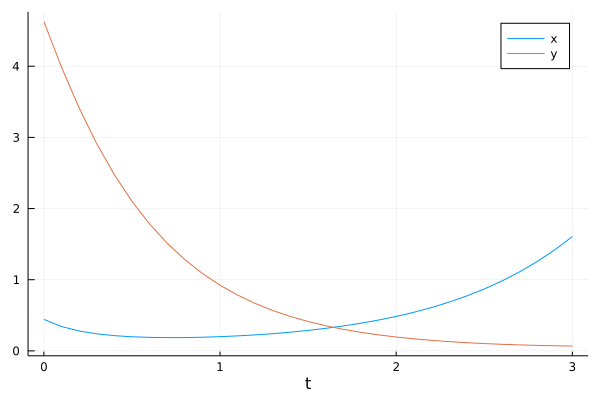

In [195]:
#plot(solution)
#plot(Array(solution)[1, :], Array(solution)[2, :])
#plot(Xₙ[1, :], Xₙ[2, :])
plot(solution.t, Xₙ[1, :], xlabel = "t", label = "x")
plot!(solution.t, Xₙ[2, :], label = "y")

## UADE

In [196]:
# Neural network

L = FastChain(FastDense(2, 32, tanh), FastDense(32, 32, tanh), FastDense(32, 2))
p = initial_params(L)


# ODE

function dudt_(u, p, t)
    x, y = u
    z = L(u,p)
    [p_[1]*x + z[1],
    -p_[4]*y + z[2]]
end

# ODE problem
prob_nn = ODEProblem(dudt_, u0, tspan, p)
sol_nn = solve(prob_nn, Tsit5(), u0 = u0, p = p, saveat = 0.1);

## Plot the untrained solution

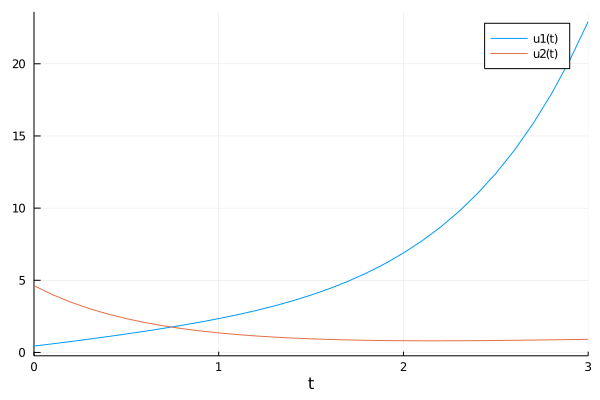

In [198]:
plot(sol_nn, xlabel = "t")
#plot(Array(sol_nn)[1, :], Array(sol_nn)[2, :])

## Loss function

In [199]:
# This function is used in the loss
function predict(θ)
    Array(solve(prob_nn, Vern7(), u0 = u0, p=θ, saveat = 0.1,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end


# No regularisation right now
function loss(θ)
    pred = predict(θ)
    sum(abs2, Xₙ .- pred)
end


# Test
#loss(p)


const losses = []

# The callback function is cb(p,args...) where the arguments are the extra returns from the loss
callback(θ, l) = begin
    push!(losses, l)
    if length(losses)%10==0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")    
    end
    
    # The callback function must return a boolean where if true, then the optimizer will prematurely end the optimization
    false
end

callback (generic function with 1 method)

## Training with ADAM

In [200]:
# Train with ADAM
res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 300)

loss: 42.5:   3%|██                                     |  ETA: 0:01:21

Current loss after 10 iterations: 42.54313


loss: 24.6:   7%|███                                    |  ETA: 0:01:17

Current loss after 20 iterations: 24.554058


loss: 18.5:  10%|████                                   |  ETA: 0:01:12

Current loss after 30 iterations: 18.520695


loss: 14.7:  13%|██████                                 |  ETA: 0:01:08

Current loss after 40 iterations: 14.673275


loss: 11.6:  17%|███████                                |  ETA: 0:01:08

Current loss after 50 iterations: 11.550282


loss: 8.9:  20%|█████████                               |  ETA: 0:01:08

Current loss after 60 iterations: 8.901139


loss: 6.75:  23%|██████████                             |  ETA: 0:01:05

Current loss after 70 iterations: 6.7494287


loss: 5.15:  27%|███████████                            |  ETA: 0:01:01

Current loss after 80 iterations: 5.147497


loss: 4.08:  30%|████████████                           |  ETA: 0:00:57

Current loss after 90 iterations: 4.0821357


loss: 3.44:  33%|█████████████                          |  ETA: 0:00:54

Current loss after 100 iterations: 3.4367347


loss: 3.03:  37%|███████████████                        |  ETA: 0:00:51

Current loss after 110 iterations: 3.0285327


loss: 2.71:  40%|████████████████                       |  ETA: 0:00:48

Current loss after 120 iterations: 2.7147677


loss: 2.44:  43%|█████████████████                      |  ETA: 0:00:45

Current loss after 130 iterations: 2.4404707


loss: 2.2:  47%|███████████████████                     |  ETA: 0:00:42

Current loss after 140 iterations: 2.1981742


loss: 1.99:  50%|████████████████████                   |  ETA: 0:00:39

Current loss after 150 iterations: 1.9902048


loss: 1.82:  53%|█████████████████████                  |  ETA: 0:00:36

Current loss after 160 iterations: 1.8182698


loss: 1.68:  57%|███████████████████████                |  ETA: 0:00:34

Current loss after 170 iterations: 1.6811569


loss: 1.58:  60%|████████████████████████               |  ETA: 0:00:31

Current loss after 180 iterations: 1.5751489


loss: 1.5:  63%|██████████████████████████              |  ETA: 0:00:28

Current loss after 190 iterations: 1.49521


loss: 1.44:  67%|██████████████████████████             |  ETA: 0:00:26

Current loss after 200 iterations: 1.4355596


loss: 1.39:  70%|████████████████████████████           |  ETA: 0:00:23

Current loss after 210 iterations: 1.3903548


loss: 1.35:  73%|█████████████████████████████          |  ETA: 0:00:20

Current loss after 220 iterations: 1.3545512


loss: 1.32:  77%|██████████████████████████████         |  ETA: 0:00:18

Current loss after 230 iterations: 1.3242885


loss: 1.3:  80%|█████████████████████████████████       |  ETA: 0:00:15

Current loss after 240 iterations: 1.2969719


loss: 1.27:  83%|█████████████████████████████████      |  ETA: 0:00:13

Current loss after 250 iterations: 1.2710035


loss: 1.25:  87%|██████████████████████████████████     |  ETA: 0:00:10

Current loss after 260 iterations: 1.2455045


loss: 1.22:  90%|████████████████████████████████████   |  ETA: 0:00:08

Current loss after 270 iterations: 1.2200267


loss: 1.19:  93%|█████████████████████████████████████  |  ETA: 0:00:05

Current loss after 280 iterations: 1.194362


loss: 1.17:  97%|██████████████████████████████████████ |  ETA: 0:00:03

Current loss after 290 iterations: 1.1684294


loss: 1.14: 100%|███████████████████████████████████████| Time: 0:01:15


Current loss after 300 iterations: 1.1421957


 * Status: success

 * Candidate solution
    Final objective value:     1.142196e+00

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   82  (vs limit Inf)
    Iterations:    300
    f(x) calls:    300
    ∇f(x) calls:   300


## Training with BFGS

In [201]:
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 1000)

Current loss after 310 iterations: 0.116165765
Current loss after 320 iterations: 0.06264582
Current loss after 330 iterations: 0.017187783
Current loss after 340 iterations: 0.01061642
Current loss after 350 iterations: 0.0041623795
Current loss after 360 iterations: 0.0032958202
Current loss after 370 iterations: 0.002618848
Current loss after 380 iterations: 0.002240337
Current loss after 390 iterations: 0.0019475014
Current loss after 400 iterations: 0.0014956768
Current loss after 410 iterations: 0.0012961525
Current loss after 420 iterations: 0.0012055686
Current loss after 430 iterations: 0.0011155138
Current loss after 440 iterations: 0.00097257784
Current loss after 450 iterations: 0.0006272974
Current loss after 460 iterations: 0.00017600511
Current loss after 470 iterations: 0.000114523944
Current loss after 480 iterations: 8.920642e-5
Current loss after 490 iterations: 7.1470655e-5
Current loss after 500 iterations: 6.941515e-5
Current loss after 510 iterations: 4.5209275e-

 * Status: failure

 * Candidate solution
    Final objective value:     7.845282e-06

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.19e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.33e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.61e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.23e-03 ≰ 0.0e+00
    |g(x)|                 = 6.05e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   110  (vs limit Inf)
    Iterations:    288
    f(x) calls:    1011
    ∇f(x) calls:   1011


## Plot the loss

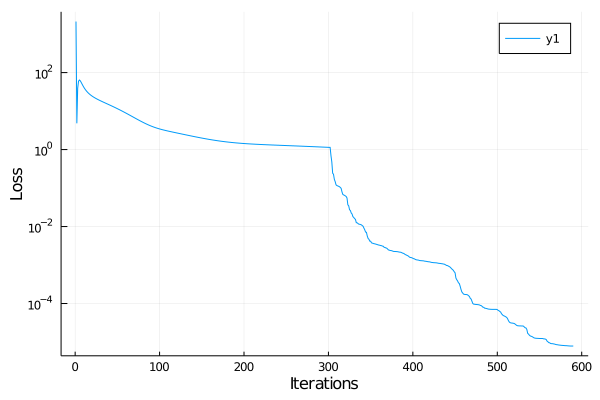

In [203]:
plot(losses, yaxis=:log, xlabel = "Iterations", ylabel = "Loss")

## Prediction

In [210]:
function dudt2_(u, p, t)
    x, y = u
    z = L(u,p)
    [p_[1]*x + z[1],
    -p_[4]*y + z[2]]
end

# ODE problem
tspan2 = (0.0f0, 5.0f0)
prob_nn2 = ODEProblem(dudt2_, u0, tspan2, res2.minimizer)
sol_nn2 = solve(prob_nn2, Tsit5(), u0 = u0, saveat = 0.1);

## Plot the approximation and the original data

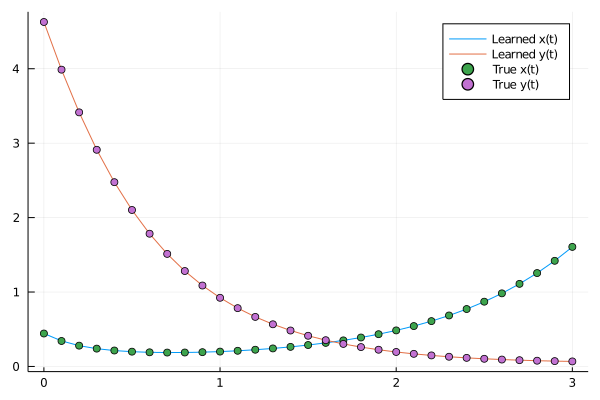

In [211]:
# Plot the data and the approximation
NNsolution = predict(res2.minimizer)
# Trained on noisy data vs real solution
plot(solution.t, NNsolution', label = ["Learned x(t)" "Learned y(t)"])
scatter!(solution.t, X', label = ["True x(t)" "True y(t)"])

## Test the prediction

In [212]:
tspan_test = (0.0f0, 5.0f0)
prob_test = ODEProblem(LV, u0, tspan_test, p_)
solution_test = solve(prob_test, Vern7(), saveat = 0.05);

## Plot Toghether True And Prediction
### Phase Space Plot

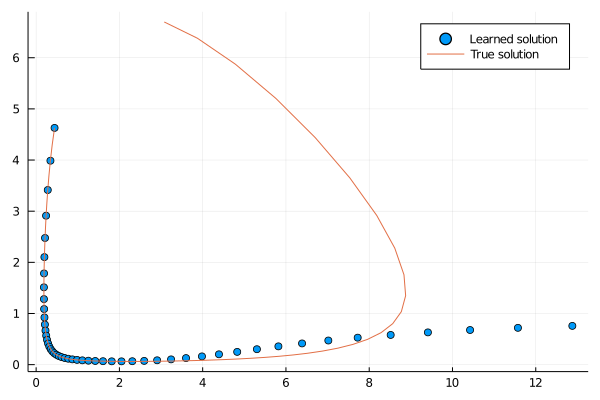

In [213]:
#scatter(Array(solution_test)[1, :], Array(solution_test)[2, :])
scatter(Array(sol_nn2)[1, :], Array(sol_nn2)[2, :], label = "Learned solution")
plot!(Array(solution_test)[1, :], Array(solution_test)[2, :], label = "True solution")

## Plot $x(t)$ and $y(t)$

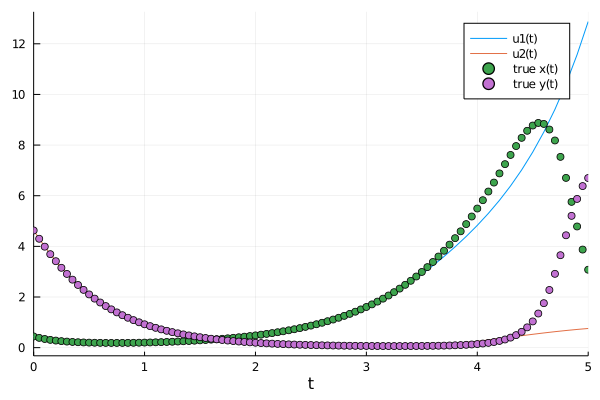

In [214]:
plot(sol_nn2)
scatter!(solution_test.t, Array(solution_test)[1, :], label = "true x(t)")
scatter!(solution_test.t, Array(solution_test)[2, :], label = "true y(t)")

# SINDy Sparse Identification of Non-linear Dynamics
### Ideal derivatives

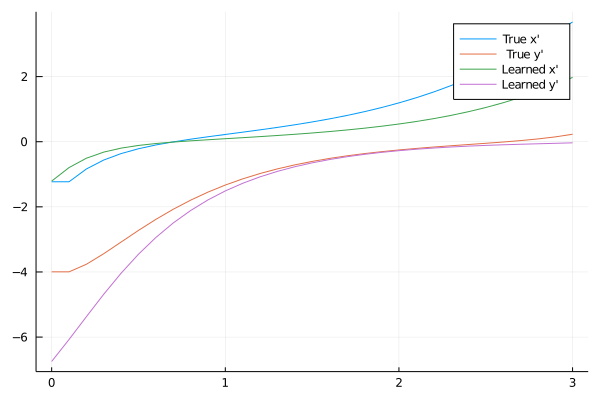

In [215]:
X = Array(solution(solution.t, Val{1}))

prob_nn2 = ODEProblem(dudt_, u0, tspan, res2.minimizer)
_sol = solve(prob_nn2, Tsit5())
DX_ = Array(_sol(solution.t, Val{1}))

plot(solution.t, DX', label = ["True x'" " True y'"])
plot!(solution.t, DX_', label = ["Learned x'" "Learned y'"])

## The learned derivatives

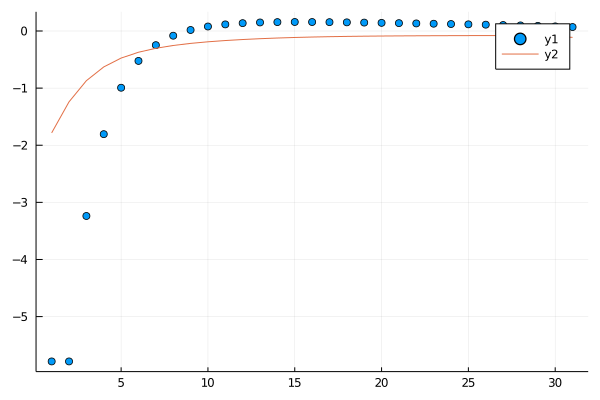

In [230]:
# Ideal data
L̄ = [-p_[2]*(X[1,:].*X[2,:])';p_[3]*(X[1,:].*X[2,:])']
# Neural network guess
L̂ = L(Xₙ, res2.minimizer)

scatter(L̄'[:, 1])
plot!(L̂'[:, 1])

# Plot the error
#scatter(abs.(L̄-L̂)', yaxis = :log)

In [231]:
# Create a Basis
@variables u[1:2]

# Lots of polynomials
polys = Operation[1]

for i ∈ 1:5
    push!(polys, u[1]^i)
    push!(polys, u[2]^i)
    for j ∈ i:5
        if i != j
            push!(polys, (u[1]^i)*(u[2]^j))
            push!(polys, u[2]^i*u[1]^i)
        end
    end
end

# And some other stuff
h = [cos.(u)...; sin.(u)...; polys...]
basis = Basis(h, u)


29 dimensional basis in ["u₁", "u₂"]

## Optimizer for the SINDy problem

In [232]:
opt = SR3()

# Create the thresholds which should be used in the search process
λ = exp10.(-7:0.1:3)

# Target function to choose the results from; x = L0 of coefficients and L2-Error of the model
g(x) = x[1] < 1 ? Inf : norm(x, 2)

g (generic function with 1 method)

## Test on original data and without further knowledge

In [233]:
println("SINDy on full ideal, unavailable data")
Ψ = SINDy(Xₙ[:, :], DX[:, :], basis, λ, opt, g = g, maxiter = 10000) # Fail
println(Ψ)
print_equations(Ψ)

SINDy on full ideal, unavailable data
Sparse Identification Result
No. of Parameters : 5
Active terms : 5
   Equation 1 : 3
   Equation 2 : 2
Overall error (L2-Norm) : 4.2228165
   Equation 1 : 3.2700117
   Equation 2 : 0.952805
AICC :
   Equation 1 : 2.799287
   Equation 2 : 5.082269

SR3{Float64,UnionAll}(0.5, 1.0, ProximalOperators.NormL1) converged after 6163 iterations.

2 dimensional basis in ["u₁", "u₂"]
du₁ = sin(u₁) * p₂ + cos(u₂) * p₁ + u₁ ^ 2 * p₃
du₂ = sin(u₂) * p₄ + p₅ * u₂



## Test on UODE derivative data

In [234]:
println("SINDy on learned, partial, available data")
Ψ = SINDy(Xₙ[:, 2:end], L̂[:, 2:end], basis, λ,  opt, g = g, maxiter = 10000, normalize = true, denoise = true) # Succeed
println(Ψ)
print_equations(Ψ)

SINDy on learned, partial, available data
Sparse Identification Result
No. of Parameters : 2
Active terms : 2
   Equation 1 : 1
   Equation 2 : 1
Overall error (L2-Norm) : 0.09001007
   Equation 1 : 0.05854563
   Equation 2 : 0.03146444
AICC :
   Equation 1 : 13.79624
   Equation 2 : 16.280033

SR3{Float64,UnionAll}(0.012559432157547899, 1.0, ProximalOperators.NormL1) did not converge after 10000 iterations.

2 dimensional basis in ["u₁", "u₂"]
du₁ = p₁ * u₁ * u₂
du₂ = p₂ * u₁ * u₂



## Extract the parameter

In [235]:
p̂ = parameters(Ψ)
println("First parameter guess : $(p̂)")

First parameter guess : Float32[-0.87934774, 0.7908027]


In [238]:
unknown_sys = ODESystem(Ψ)
unknown_eq = ODEFunction(unknown_sys)

(::ODEFunction{true,DiffEqBase.EvalFunc{ModelingToolkit.var"#f#169"{ModelingToolkit.var"#544#545",ModelingToolkit.var"#546#547"}},UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Array{Symbol,1},Nothing}) (generic function with 7 methods)

In [241]:
function dudt(du, u, p, t)
    # Add SINDy Term
    α, δ, β, γ = p
    z = unknown_eq(u, [β; γ], t)
    du[1] = α*u[1] + z[1]
    du[2] = -δ*u[2] + z[2]
end

dudt (generic function with 1 method)

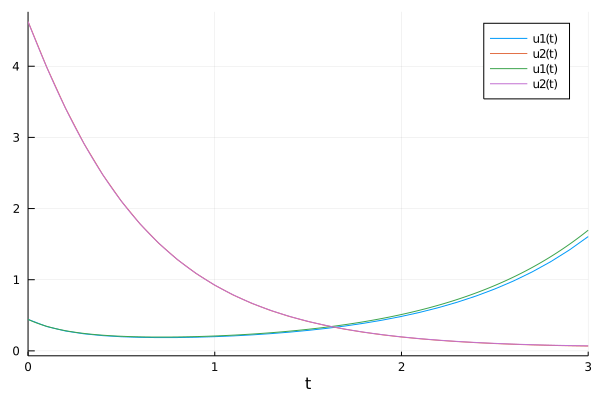

In [244]:
# Create the approximated problem and solution
ps = [p_[[1,4]]; p̂]
approximate_prob = ODEProblem(dudt, u0, tspan, ps)
approximate_solution = solve(approximate_prob, Tsit5(), saveat = 0.01)

# Plot
plot(solution)
plot!(approximate_solution)

## Look at long term prediction

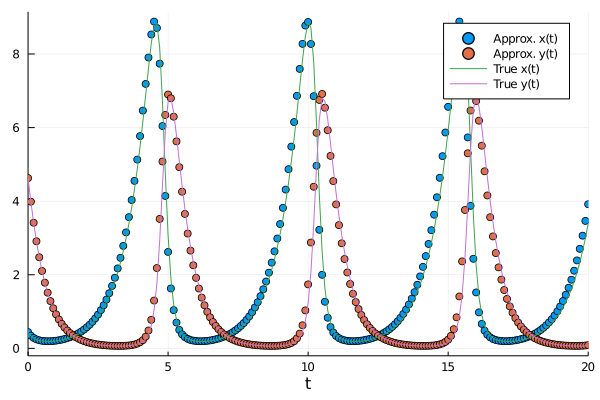

In [250]:
t_long = (0.0, 20.0)
approximate_prob = ODEProblem(dudt, u0, t_long, ps)
approximate_solution_long = solve(approximate_prob, Tsit5(), saveat = 0.1) # Using higher tolerances here results in exit of julia
scatter(approximate_solution_long, label = ["Approx. x(t)" "Approx. y(t)"])

true_prob = ODEProblem(LV, u0, t_long, p_)
true_solution_long = solve(true_prob, Tsit5(), saveat = approximate_solution_long.t)
plot!(true_solution_long, label = ["True x(t)" "True y(t)"])